In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as nnf
import torch.nn as nn
from torchvision import transforms


from utils.metrics import validation_scores
from models.completion.AE import AE
from utils.datasets import CIFAR_SR_completion


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 100
batch_size = 8
scalefactor = 2
latent_dims = [64]
channels = [32, 64, 128, 256]
in_channels = 3
base_width = 16
model = AE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          base_width=base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, base_width, base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, base_width, base_width), (1, in_channels, 32, 32)])

torch.Size([1, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 3, 32, 32]            --
├─AELREncoder: 1-1                       [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           128
│    └─Conv2d: 2-2                       [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-3                       [1, 128, 4, 4]            131,200
│    └─Linear: 2-4                       [1, 64]                   131,136
├─AEDecoder: 1-2                         [1, 3, 32, 32]            --
│    └─Linear: 2-5                       [1, 4096]                 266,240
│    └─ConvTranspose2d: 2-6              [1, 128, 8, 8]            524,416
│    └─ConvTranspose2d: 2-7              [1, 64, 16, 16]           131,136
│    └─ConvTranspose2d: 2-8              [1, 32, 32, 32]           32,800
│    └─Conv2d: 2-9                       [1, 3, 32, 32]            99
Total params: 1,249,987
Trainable params: 1,249,987

In [3]:
train_dataset = CIFAR_SR_completion(scale_factor=scalefactor, split='train')
test_dataset = CIFAR_SR_completion(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

#means = []
#stds = []
#for img in train_loader:
#    means.append(torch.mean(img[1]))
#    stds.append(torch.std(img[1]))

#mean = torch.mean(torch.tensor(means))
#std = torch.mean(torch.tensor(stds))

Dataset Loaded: 50000 training samples, 10000 validation samples


In [4]:
#print(mean,std)

In [5]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:20]
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG weights
        self.vgg = vgg

    def forward(self, pred, target):
        pred_features = self.vgg(pred)
        target_features = self.vgg(target)
        return nnf.mse_loss(pred_features, target_features)  # Feature-level loss
perceptual_loss = PerceptualLoss().to(device)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

c:\Users\Kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# means1, stds1 = [], []
# means2, stds2 = [], []
# means3, stds3 = [], []
# for HR, LR, LR_UP in train_loader:
#     means1.append(torch.mean(HR[1][0]))
#     stds1.append(torch.std(HR[1][0]))
#     means2.append(torch.mean(HR[1][1]))
#     stds2.append(torch.std(HR[1][1]))
#     means3.append(torch.mean(HR [1][2]))
#     stds3.append(torch.std(HR[1][2]))


# mean1 = torch.mean(torch.tensor(means1))
# std1 = torch.mean(torch.tensor(stds1))
# mean2 = torch.mean(torch.tensor(means2))
# std2 = torch.mean(torch.tensor(stds2))
# mean3 = torch.mean(torch.tensor(means3))
# std3 = torch.mean(torch.tensor(stds3))
# print(mean1, std1)
# print(mean2, std2)
# print(mean3, std3)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0


    for HR, LR, LR_UP in train_loader:

        optimizer.zero_grad()
        recon_imgs = model(LR, LR_UP)
        normalize = transforms.Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
        HR = normalize(HR)
        HR = transforms.Resize((224, 224))(HR)
        recon_imgs = normalize(recon_imgs)
        recon_imgs = transforms.Resize((224, 224))(recon_imgs)
        loss = perceptual_loss(recon_imgs, HR)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.2f}")
    model.loss.append(total_loss)


[]

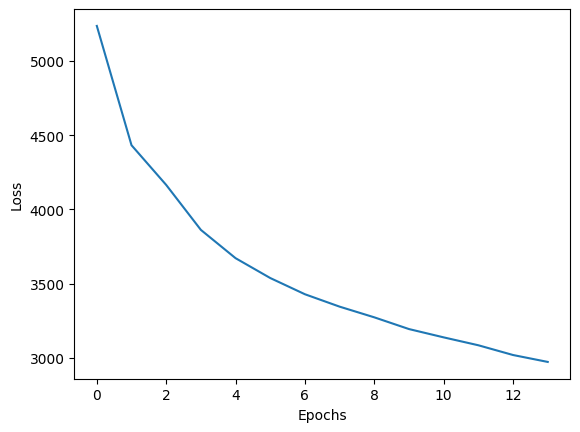

In [ ]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [ ]:
HR, LR, LR_UP = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [ ]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(4, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')
            axs[3, i].set_title('Low Resolution Upscaled')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

        axs[3, i].imshow(LR_UP[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[3, i].axis('off')

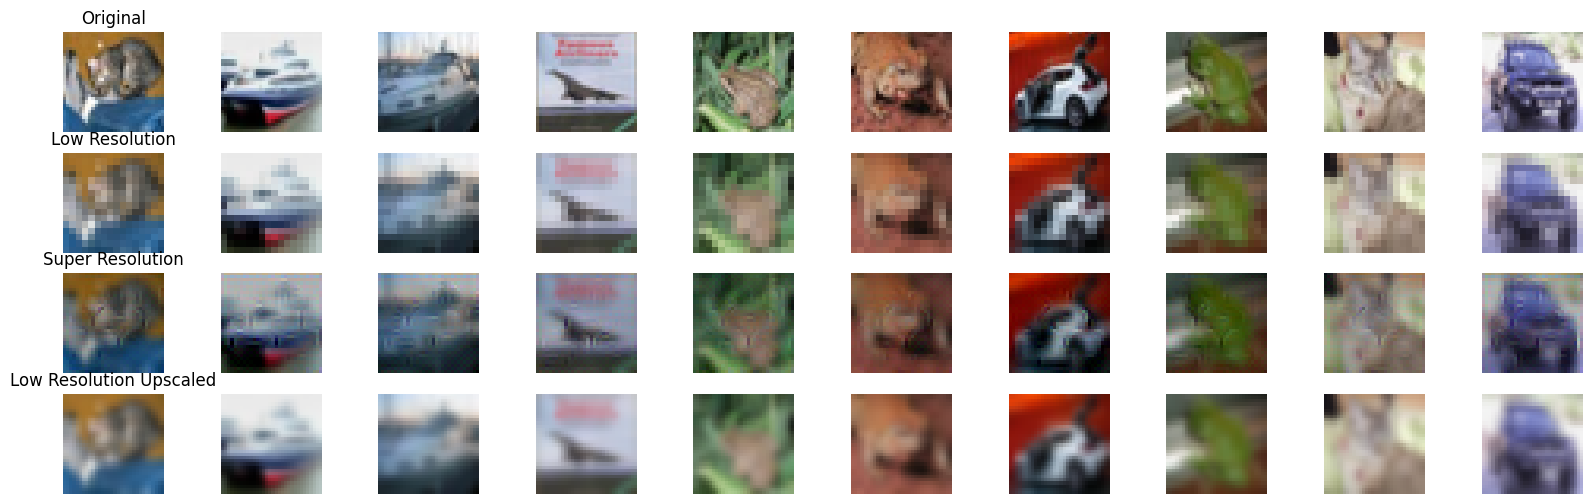

In [ ]:
show_image(HR, LR, SR, 10)

In [ ]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

PSNR: 16.10884666442871
SSIM: 0.6323630213737488
LPIPS: 0.2066447138786316
BRISQUE: 75.38133239746094
PSNR Consistency: 17.017078399658203
MSE Diversity: 6.701565485182199e-17
LPIPS Diversity: 6.674618800200829e-12
